In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
#import cv2
import torch
import sys
from tqdm import tqdm
import nibabel as nib

sys.path.append('/workspace/MRI-inpainting-project/data_scripts')
sys.path.append('/workspace/MRI-inpainting-project/I2SB/dataset')

from datasets import TrainPatchesDataset, HealthyMRIDataset, PathologicalMRIDataset
from mri_datasets import ReconMRIDataset, TrainPatchesDataset
from visualization_utils import ImageSliceViewer3D

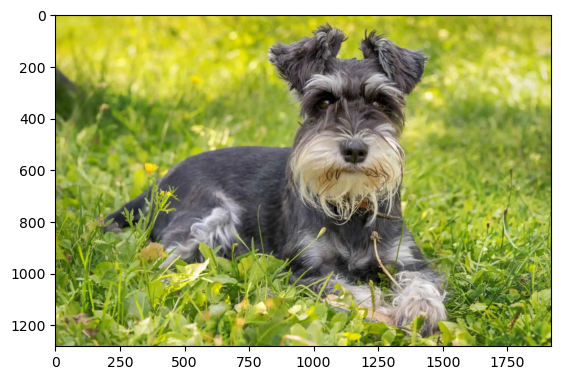

In [2]:
image_list = os.listdir('../data/zwerg_data/train/class1')
img = plt.imread('../data/zwerg_data/train/class1/zwerg.jpg')
plt.imshow(img)

In [3]:
img.shape

(1282, 1920, 3)

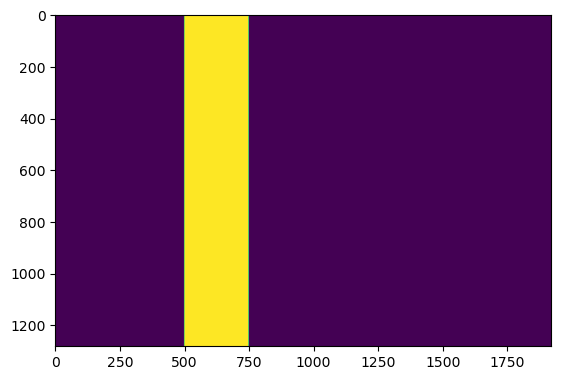

In [4]:
mask = np.zeros((1282, 1920))
mask[:, 500:750] = 1
plt.imshow(mask)

In [5]:
mask = cv2.resize(mask, (256, 256))
mask = np.concatenate([mask[None, :, :]]*3)
mask.shape

(3, 256, 256)

In [19]:
np.savez('../data/imagenet_freeform1020_masks.npz', mask=mask.astype(np.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


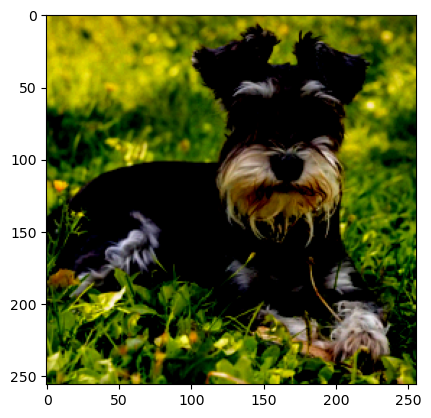

In [6]:
recons = torch.load('../results/ZwergTest/samples_nfe999/recon.pt')['arr']
plt.imshow(recons[2].permute(1, 2, 0))

In [1]:
import sys
sys.path.append('/workspace/I2SB')

from utils.data_utils import HealthyBrainsDataset

/root/miniconda3/envs/i2sb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
HealthyBrainsDataset()

In [2]:
recons = torch.load("../results/Split0Flair/samples_nfe999/recon.pt")['arr']

In [3]:
recons1 = recons[:16]

In [4]:
recons1 = torch.nn.functional.interpolate(recons1, size=(40, 40), mode='bilinear', align_corners=False)

In [5]:
recons1.shape

torch.Size([16, 3, 40, 40])

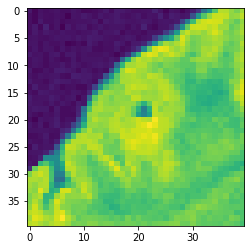

In [37]:
plt.imshow(recons1[8].mean(axis=0))

In [7]:
healthy_dataset = HealthyMRIDataset('/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_mri_flair',
                                    '/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_masks_t1/sphere_masks/masks',
                                    '/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_masks_t1/sphere_masks/patch_masks')
recons_path = "/workspace/MRI-inpainting-project/I2SB/results/Split0Flair/samples_nfe999/recon.pt"

In [39]:
mri, patch_mask, mask = healthy_dataset[0]['mri'], healthy_dataset[0]['patch_mask'], healthy_dataset[0]['mask']

In [40]:
left = np.where(patch_mask > 0)[2][12]
right = np.where(patch_mask > 0)[2][28]

patch_mask[:, :, :left] = 0.0
patch_mask[:, :, right:] = 0.0

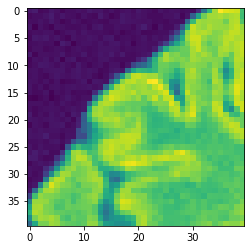

In [41]:
recon_norm = (((recons1.mean(axis=1) / 2) + 0.5) * 1457.3842)
plt.imshow(recon_norm[15])

In [42]:
mri_recon = mri.copy()
mri_recon[patch_mask > 0] = np.transpose(recon_norm, (1, 2, 0)).flatten()

In [43]:
mri_recon[patch_mask > 0].shape

(25600,)

In [52]:
ImageSliceViewer3D(mri, mask, cmap='gray', mask_intensity=0.2)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [46]:
ImageSliceViewer3D(mri_recon, mask, cmap='gray', mask_intensity=0.)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [8]:
recon_mri_dataset = ReconMRIDataset(recons_path, healthy_dataset, flair=False)

In [9]:
recon_mri_dataset[0]

ValueError: Input and output must have the same number of spatial dimensions, but got input with with spatial dimensions of [256] and output size of (40, 40). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [48]:
sample = recon_mri_dataset[1]

In [51]:
ImageSliceViewer3D(sample['mri_recon'], sample['mask'], cmap='gray', mask_intensity=0.)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [9]:
sample['filename']

'sub-00012_t1_brain-final.nii.gz'

In [86]:
mri_dataset = PathologicalMRIDataset("/workspace/MRI-inpainting-project/data/pathological_mri")

In [79]:
mask_volume = [(sample['mask'] > 0.5).sum() for sample in tqdm(mri_dataset)]

100%|██████████| 198/198 [01:21<00:00,  2.44it/s]


In [80]:
np.mean(mask_volume), np.std(mask_volume)

(4133.419191919192, 4848.950143690417)

Text(0.5, 1.0, 'FCD volume distribution')

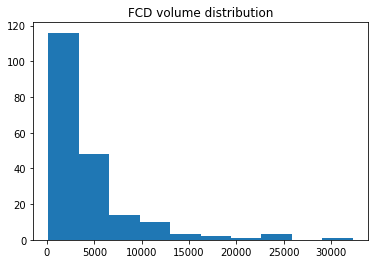

In [99]:
plt.hist(mask_volume)
plt.title('FCD volume distribution')

In [75]:
sample = mri_dataset[22]

In [74]:
(sample['mask'] > 0.5).sum()

2237

In [69]:
ImageSliceViewer3D(sample['mask'] > 0.5, cmap='gray', mask_intensity=0.4)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [88]:
ImageSliceViewer3D(sample['mri'], sample['mask'] > 0.5, cmap='gray', mask_intensity=0.3)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [2]:
train_patches = TrainPatchesDataset("/workspace/MRI-inpainting-project/data/train_patches_v3")

In [3]:
len(train_patches)

169

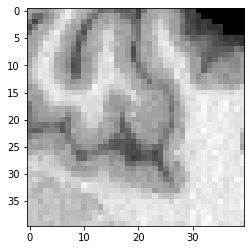

In [97]:
plt.imshow(train_patches[10]['patch'][:, :, 18], cmap='gray')

In [22]:
mri = nib.load("/workspace/Features/Features/generated_mri/i2sb/3dunet_masks_new/split3/mri/sub-00030_t1_brain-final.nii.gz").get_fdata()
mask = nib.load("/workspace/Features/Features/generated_mri/i2sb/3dunet_masks_new/split3/masks/sub-00030_t1_brain-final.nii.gz").get_fdata()

In [19]:
mri[mask > 0] = mri[mask > 0]

array([  3.56088996,  23.64807129, 117.60804749, ..., 211.2431488 ,
       213.48934937, 212.37823486])

In [25]:
ImageSliceViewer3D(mri, mask, cmap='gray', mask_intensity=0.0)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [42]:
plt.imsave('mri-gen-example.png', mri[:, :, 108], cmap='gray')

In [43]:
plt.imsave('mask-example.png', mask[:, :, 108], cmap='gray')

In [36]:
healthy_dataset = HealthyMRIDataset('/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_mri_t1')

In [45]:
plt.imsave('mri-healthy-example.png', healthy_dataset.getbyname('sub-00030_t1_brain-final.nii.gz')['mri'][:, :, 108], cmap='gray')